In [67]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install plyfile

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from plyfile import PlyData, PlyElement
from scipy.optimize import least_squares

In [3]:
def load_image(path, gray=False):
  if gray:
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # 彩色图转为灰度图
  else:
    return cv2.imread(path)

In [4]:
img1 = load_image('./drive/My Drive/jupyter-notebooks/imgs/B21.jpg')
img2 = load_image('./drive/My Drive/jupyter-notebooks/imgs/B22.jpg')
img3 = load_image('./drive/My Drive/jupyter-notebooks/imgs/B23.jpg')
img4 = load_image('./drive/My Drive/jupyter-notebooks/imgs/B24.jpg')
img5 = load_image('./drive/My Drive/jupyter-notebooks/imgs/B25.jpg')
imgs = [img1, img2, img3, img4, img5]

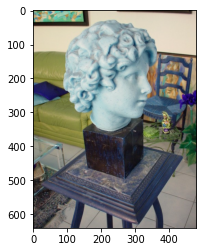

In [5]:
plt.imshow(imgs[0])
plt.show()

In [79]:
X = np.array([]) # 每个点的三维坐标
Y = np.array([])
Z = np.array([])
Colors = [] # 每个点的颜色

In [80]:
K = [] # 内参矩阵
K.append([719.5459, 0, 320])
K.append([0, 719.5459, 240])
K.append([0, 0, 1])
K = np.array(K)

In [81]:
R_t_0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]]) # 外参矩阵0
R_t_1 = np.empty((3,4))                # 外参矩阵1
P1 = np.matmul(K, R_t_0) # Camera Projection matrix
P2 = np.empty((3,4))

In [82]:
prev_img = None
prev_kp = None
prev_des = None

In [83]:
def reprojection_loss_function(opt_variables, pts, num_pts): # 损失函数
    P = opt_variables[0:12].reshape(3,4) # Camera Projection matrix
    point_3d = opt_variables[12:].reshape((num_pts, 4)) # All 3D points

    rep_error = []

    for idx, pt_3d in enumerate(point_3d):
        pt_2d = np.array([pts[0][idx], pts[1][idx], 1]) # 真实值

        pt_3d /= pt_3d[3]
        reprojected_pt = np.matmul(P, pt_3d)
        reprojected_pt /= reprojected_pt[2] # 预测值

        '''
        error = (pt_2d[0] - reprojected_pt[0]) ** 2 + \
             (pt_2d[1] - reprojected_pt[1]) ** 2 + \
             (pt_2d[2] - reprojected_pt[2]) ** 2  # 误差
        '''
        error = pt_2d - reprojected_pt  
        rep_error.append(error)
    
    return np.array(rep_error).ravel()

def bundle_adjustment(P, points_3d, pts):
    opt_variables = np.hstack((P.ravel(), points_3d.ravel(order="F"))) # 要优化的参数：P和points_3d
    num_points = len(pts[0]) # pts是实际值，即图上点的真实二维坐标

    corrected_values = least_squares(reprojection_loss_function, opt_variables, args=(pts, num_points))

    P = corrected_values.x[0:12].reshape(3,4)
    points_3d = corrected_values.x[12:].reshape((num_points, 4))

    return P, points_3d

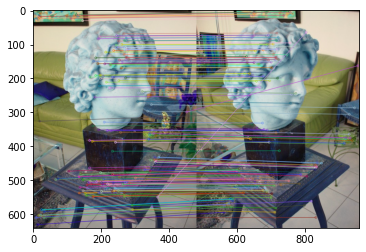

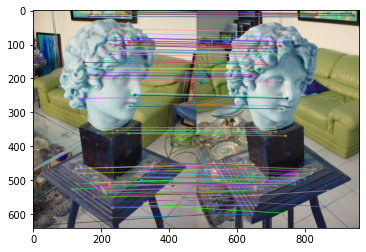

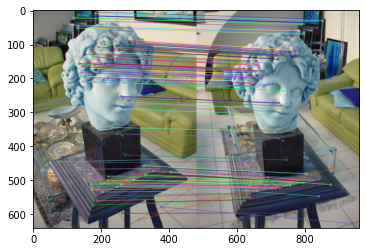

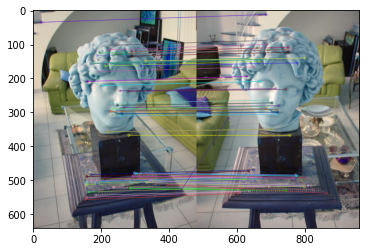

In [84]:
for i in range(len(imgs)):
  img = imgs[i]

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(img,None) # sift找出该图的关键点kp和对应描述des

  if i == 0:
    prev_img = img
    prev_kp = kp
    prev_des = des
  else:
    index_params = dict(algorithm=1, trees=6)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    match = flann.knnMatch(prev_des, des, k=2) # 关键点匹配

    result = []
    pts1 = []
    pts2 = []
    for m,n in match:
      #print(m.trainIdx)
      if m.distance < 0.6*n.distance: # 筛掉不好的匹配
        result.append([m])
        pts1.append(prev_kp[m.queryIdx].pt) # 图1中的特征点
        pts2.append(kp[m.trainIdx].pt) # 图2中对应的特征点

    img_match = cv2.drawMatchesKnn(prev_img,prev_kp,img,kp,result,None,flags=2)
    plt.imshow(img_match)
    plt.show()

    #####
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC) # 基本矩阵
    E = np.matmul(np.matmul(np.transpose(K), F), K) # 本征矩阵

    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, K) # 外参矩阵R,t
    R_t_1[:3, :3] = np.matmul(R, R_t_0[:3,:3]) # 在第一个相机坐标下的R
    R_t_1[:3, 3] = t.ravel() + np.matmul(R, R_t_0[:3, 3]) # 在第一个相机坐标下的t

    #P1 = np.matmul(K, R_t_0)
    P2 = np.matmul(K, R_t_1) # Camera Projection matrix

    for pt in pts1:
      Colors.append(img[int(pt[1])][int(pt[0])])
    
    pts1 = np.transpose(pts1)
    pts2 = np.transpose(pts2)

    points_3d = cv2.triangulatePoints(P1, P2, pts1, pts2)
    points_3d /= points_3d[3]

    #P2, points_3D = bundle_adjustment(P2, points_3d, pts2)

    X = np.concatenate((X, points_3d[0]))
    Y = np.concatenate((Y, points_3d[1]))
    Z = np.concatenate((Z, points_3d[2]))
    #####

    R_t_0 = np.copy(R_t_1)
    P1 = np.copy(P2)

    prev_img = img
    prev_kp = kp
    prev_des = des

In [85]:
vertexs = np.empty(len(X), dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
for i in range(len(X)):
  vertexs[i] = (X[i], Y[i], Z[i]) # 坐标

colors = np.empty(len(X), dtype=[('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
for i in range(len(X)):
  colors[i] = tuple(Colors[i]) # 颜色

In [86]:
vertex_all = np.empty(len(X), vertexs.dtype.descr + colors.dtype.descr)

for prop in vertexs.dtype.names:
    vertex_all[prop] = vertexs[prop] # 坐标

for prop in colors.dtype.names:
    vertex_all[prop] = colors[prop] # 颜色

ply = PlyData([PlyElement.describe(vertex_all, 'vertex')], text=True)
ply.write('sculpture.ply')

-----------

In [ ]:
print(vertexs.dtype.descr + colors.dtype.descr)

[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('red', '|u1'), ('green', '|u1'), ('blue', '|u1')]


In [ ]:
print(vertexs.dtype.names)

('x', 'y', 'z')


In [ ]:
print(vertexs[1])

(-2.2213213, 2.911028, 5.234887)


In [ ]:
print(vertexs['x'])

[-2.29599309e+00 -2.22132134e+00 -2.27620220e+00 -3.90005875e+00
 -3.89404774e+00 -3.89404774e+00 -3.12907505e+00 -2.24158072e+00
 -2.28613782e+00 -2.22565126e+00 -2.24623871e+00 -2.17734313e+00
 -2.23198199e+00 -1.12690580e+00 -1.10558820e+00 -9.94810760e-01
 -8.43557715e-01 -7.98900068e-01 -8.04014087e-01 -8.36342394e-01
 -8.30687463e-01 -8.05114448e-01 -8.07155967e-01 -7.84826517e-01
 -7.52043605e-01 -7.23024189e-01 -7.04311073e-01 -7.20310152e-01
 -7.09221363e-01 -7.01728106e-01 -7.41516769e-01 -7.14938223e-01
 -6.86720252e-01 -5.90558231e-01 -6.76934242e-01 -6.78869843e-01
 -6.79691672e-01 -6.20150506e-01 -6.20150506e-01 -5.58746696e-01
 -5.99749863e-01 -5.32435954e-01 -5.37005544e-01 -6.03466451e-01
 -5.09418964e-01 -5.27938843e-01 -5.99623561e-01 -5.79664171e-01
 -5.53703249e-01 -5.14164746e-01 -5.15060067e-01 -4.91482407e-01
 -5.82477450e-01 -4.85601842e-01 -5.23734033e-01 -5.36530197e-01
 -5.36530197e-01 -5.18896401e-01 -4.58643228e-01 -5.20491004e-01
 -4.47156131e-01 -4.34627